# Direct elicitation in 1D

In [1]:
import preliz as pz
import matplotlib.pyplot as plt

In [2]:
pz.style.use("preliz-doc")

## From intervals to maximum entropy distributions

For some priors in a model, we may know or assume that most of the mass is within a certain interval. This information is useful for determining a suitable prior, but this information alone may not be enough to obtain a unique set of parameters. The following figure shows Beta distributions with 90% of the mass between 0.1 and 0.7. As you can see this Beta distribution conveys very different prior knowledge. 


![beta_bounds](img/beta_bounds.png)

We can add one more condition, one that is very general. We can maximize the entropy. Given two distributions the one with more entropy is the less informative one. Losselly speaking, is the most "spread" one. In the previous figure, the blue line is the one with more entropy. Having priors with maximum entropy makes sense as this guarantees that we have the less informative distribution, given a set of constraints. 

In PreliZ we can compute maximum entropy priors using the function `maxent`. The first argument is a PreliZ distribution.

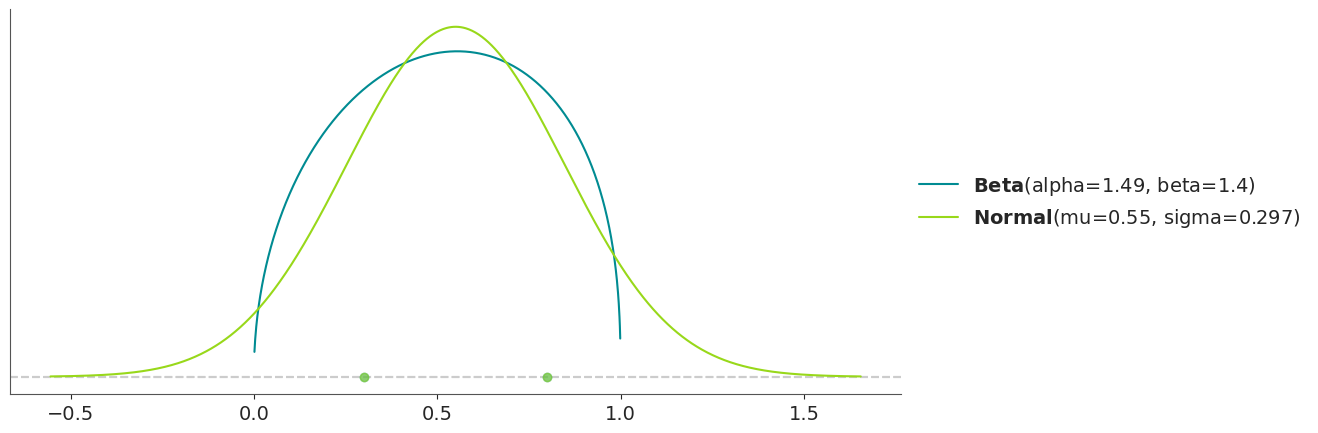

In [3]:
pz.maxent(pz.Beta(), lower=0.3, upper=0.8, mass=0.6)
pz.maxent(pz.Normal(), lower=0.3, upper=0.8, mass=0.6);

Usually, we pass uninitialized distribution to `maxent`. But we can also pass partially initialized distribution. This is useful when we want to keep one or more parameters fixed. For instance, we may want to find a Gamma distribution with a mean of 4 and with 90% of the mass between 1 and 10.

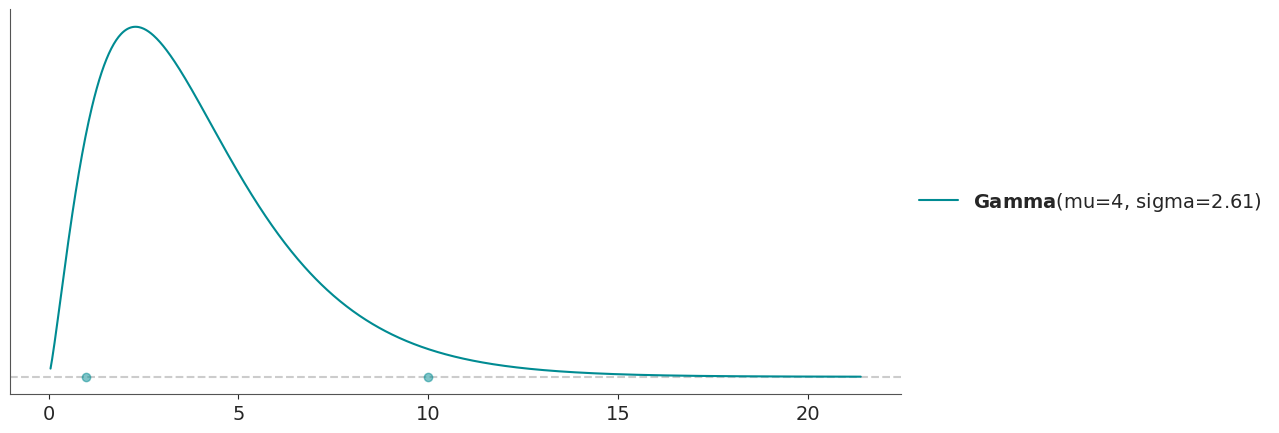

In [4]:
pz.maxent(pz.Gamma(mu=4), 1, 10, 0.9);

If you pass a distribution with all the parameters specified, like `pz.Gamma(mu=4, sigma=1)`, you will get an error saying "All parameters are fixed, at least one should be free".

Many functions in PreliZ update distribution in place, `maxent` is no exception. So sometimes it is best to first instantiate a distribution, and they use it, like this:

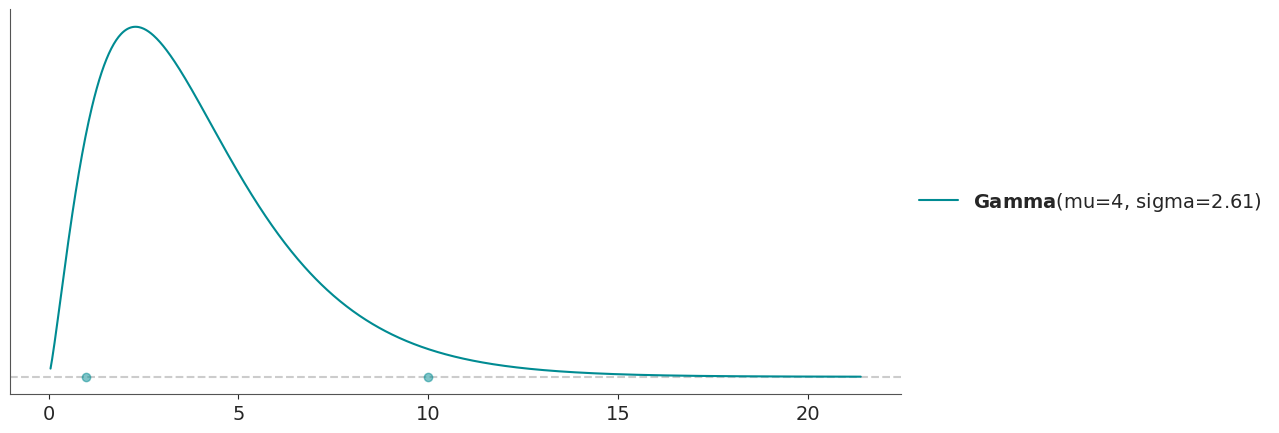

In [5]:
dist = pz.Gamma(mu=4)
pz.maxent(dist, 1, 10, 0.9);

this will allow us to keep working with `dist`, for instance to get its parameters

In [6]:
dist.alpha, dist.beta

(2.341680163267631, 0.5854200408169078)

## From intervals and quartiles to distributions

One alternative to `maxent` is to define a distribution by its [quartiles](https://en.wikipedia.org/wiki/Quartile), that is by the 3 points which divides the distribution into 4 parts each with 25% of the total mass.

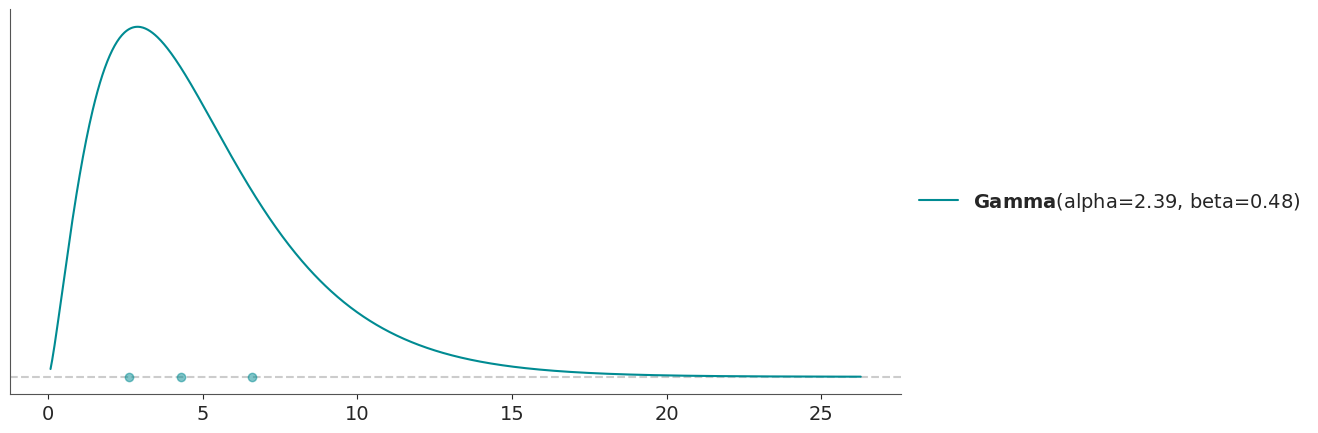

In [7]:
pz.quartile(pz.Gamma(), 2.6, 4.3, 6.6);

Sometimes, there is no distribution capable of satisfying our constraints. When the difference between what we asked and what PreliZ was able to compute is large enough, PreliZ will warn us. This will help us to decide if the computed distribution is still useful, or we need to change the inputs.

/tmp/ipykernel_42436/3996526084.py:1: UserWarning: 
The expected masses are 0.25, 0.5, 0.75
The computed ones are: 0.29, 0.44, 0.77
  pz.quartile(pz.Gamma(), 3, 4, 7);


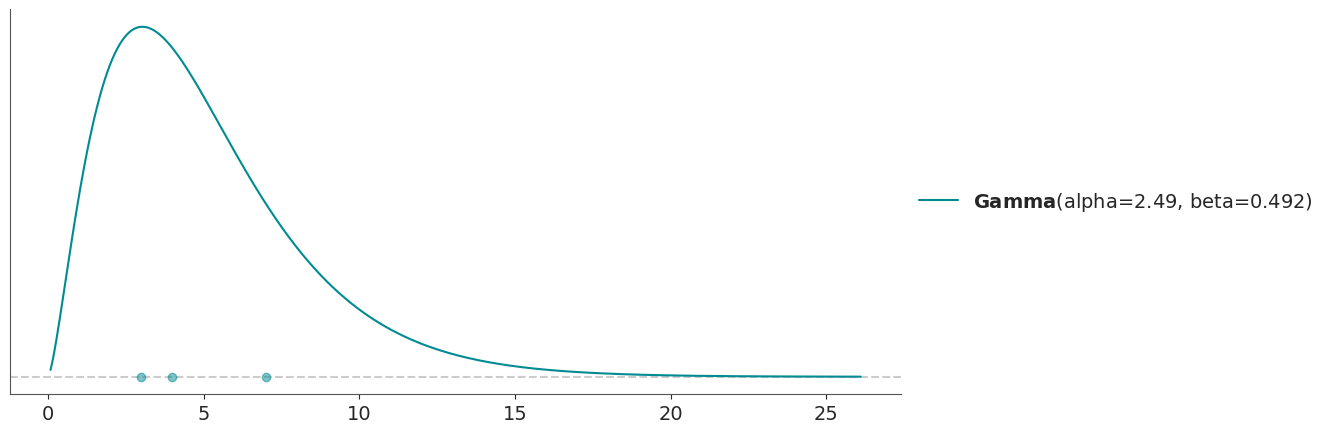

In [8]:
pz.quartile(pz.Gamma(), 3, 4, 7);

Another function that allows to specify distribution in terms of quartiles is `quartile_int`. This is like `quartile`, but it is interactive and we can pass a list of distribution families. The function will return the closest 1D distribution to that input.

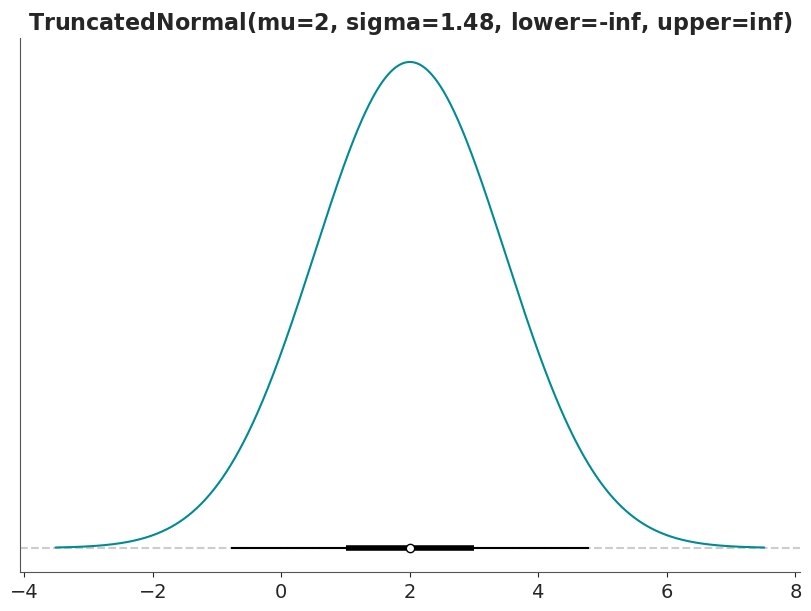

In [9]:
%matplotlib widget
pz.QuartileInt(1, 2, 3, ["StudentT", "TruncatedNormal", "BetaScaled"]);

As you can see, to run this function we first need to call the `matplotlib widget` magic, we also needs to have ipywidgets installed (an optional requirement of PreliZ).

Notice that to specify the list of available distributions, we pass a list of strings, instead of a list of PreliZ's distributions. The `params` box, allows us to fix parameters for one or more distributions.

If you are unable to run the previous cell, you can get a glimpse of `quartile_int` from this gif

![quartile_int](img/quartile_int.gif)

Before continuing we close the interactive figure and reinitialize the standard backend.

In [10]:
plt.close()
%matplotlib inline

## From samples to maximum likelihood distributions

For some problems, we may have data that we can use to inform priors. One way to do it is to fit the data to some parametric family of distributions. We can then use a maximum likelihood estimate to get the distribution with the best fit. To rank the distributions we use the Akaike Criterion, which includes a [penalization term](https://en.wikipedia.org/wiki/Akaike_information_criterion#Modification_for_small_sample_size) related to the number of parameters of each distribution.

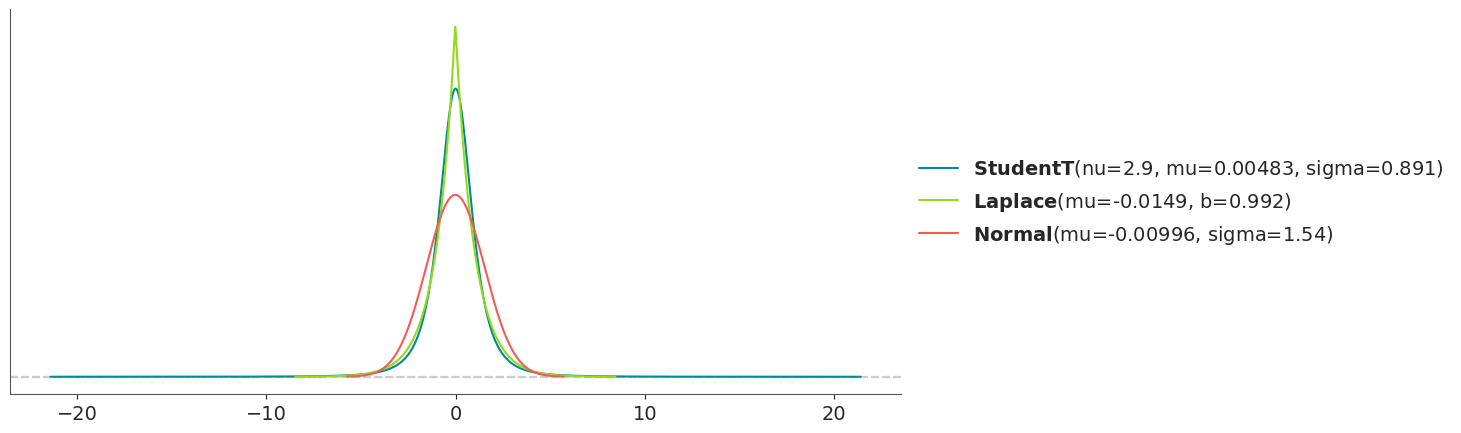

In [11]:
# In a real scenario this will be some data and not a sample from a PreliZ distribution
sample = pz.StudentT(4, 0, 1).rvs(1000) 

dist0 = pz.StudentT()
dist1 = pz.Normal()
dist2 = pz.Laplace()
pz.mle([dist0, dist1, dist2], sample, plot=3);  # we ask to plot all 3 distributions

By default `pz.mle` only plots the best match, but here we decided to get a plot with the 3 fitted distributions. As with `maxent` the distributions are updated in place so we can get access to them.

In [12]:
dist0

StudentT(nu=2.9, mu=0.00483, sigma=0.891)

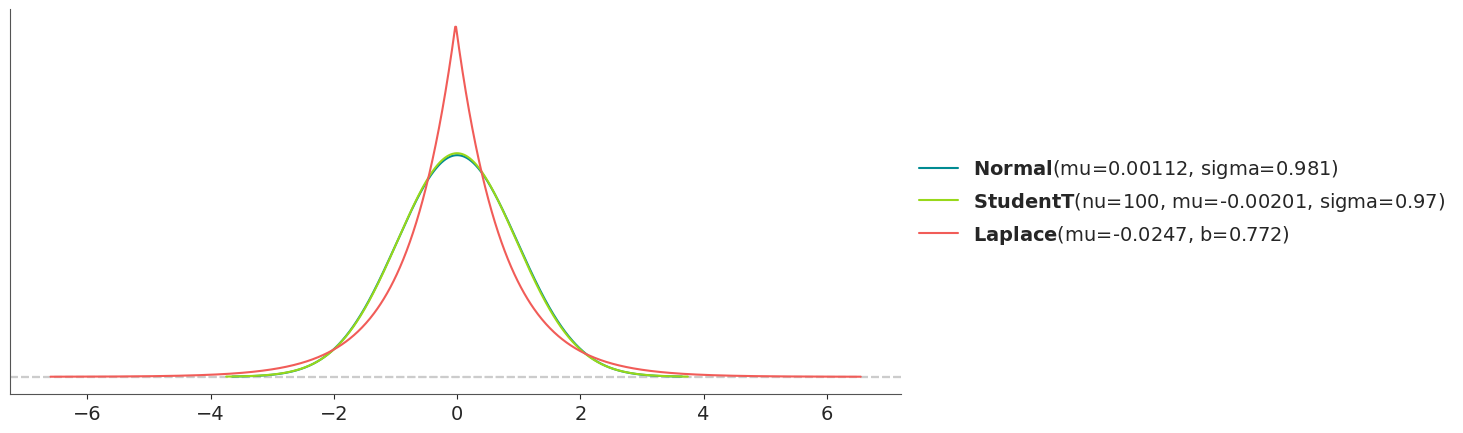

In [13]:
# In a real scenario this will be some data and not a sample from a PreliZ distribution
sample = pz.StudentT(5000, 0, 1).rvs(1000) 

dist0 = pz.StudentT()
dist1 = pz.Normal()
dist2 = pz.Laplace()
pz.mle([dist0, dist1, dist2], sample, plot=3);  # we ask to plot all 3 distribution

## The roulette method

The roulette method allows us to find a prior distribution by *drawing*. The name roulette comes from the analogy that we are placing a limited set of chips where we think the mass of a distribution should be.

For this task, we are offered a grid of `m` equally sized bins covering the range of `x`. And we have to allocate a total of `n` chips between the bins. In other words, we use a grid to draw a histogram and the function will try to tell us what distribution, from a given pool of options, is a better fit for our drawing.

To use the `Roulette` we need to first call `%matplotlib widget` and have ipywidgets installed.

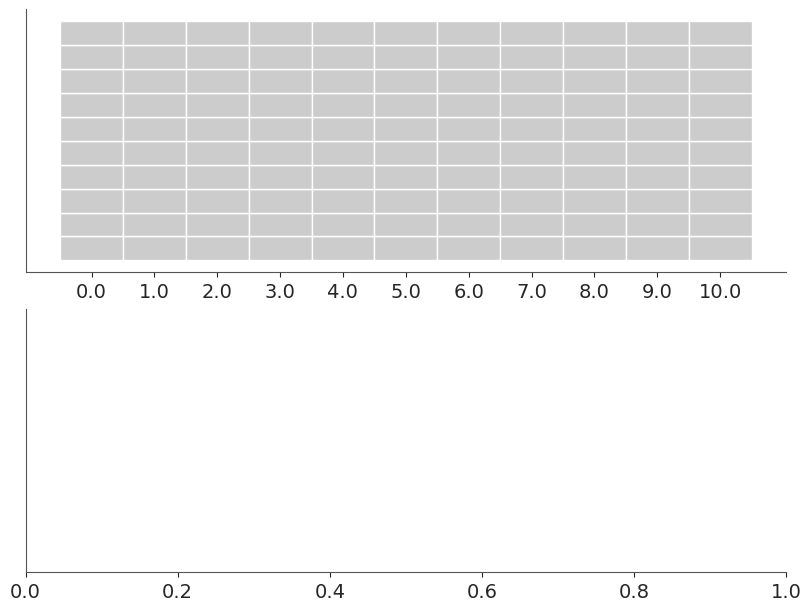

In [14]:
%matplotlib widget
result = pz.Roulette()

If you are unable to run the previous cell, you can get a glimpse of `roulette` from this gif

![roulette](roulette.gif)

 Once you have elicited the distribution you can call `.dist` attribute to get the distribution. In the following example, it will be `result.dist`. 


You can combine results for many independent "roulette sessions". This could be useful to combine information from different sources, like different domain experts. Or even from a single person unable to pick a single option.

Anyway, let's say that you run `Roulette` twice, for the first one you get `result0` and for the second `result1`. Then you can combine both solutions into a single one using

`pz.combine_roulette([result0.inputs, result1.inputs], weights=[0.3, 0.7])`

In this example, we are giving more weight (or importance) to the results from the second elicitation session. By default the weights are equal.

In [15]:
plt.close()
%matplotlib inline

## From intervals and mode to a Beta distribution

All previous methods are very general. But we also have one method specific for the Beta distribution. This method is similar to maxent, but instead of specifying a maximum entropy prior, we specify the mode.

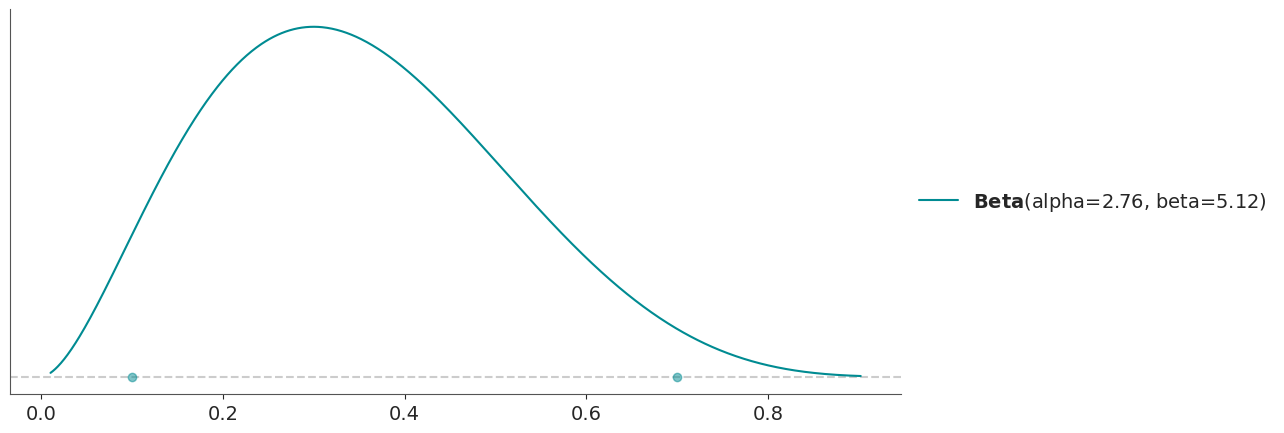

In [16]:
pz.beta_mode(0.1, 0.7, mode=0.3);